In [1]:
from nbed.driver import NbedDriver
from nbed.ham_builder import HamiltonianBuilder
from openfermion import get_sparse_operator
import scipy as sp
from openfermion.utils import count_qubits
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from nbed.mol_plot import Draw_molecule

/home/lex/anaconda3/envs/embed/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
current_dir = os.getcwd()
structure_dir =  os.path.join(current_dir, "molecular_structures")

In [3]:
# order by R_length
all_xyz_files = sorted(os.listdir(structure_dir), 
                       key=lambda text: int(text.partition("H2O_")[2].partition(".xyz")[0]))
all_xyz_files

['H2O_5.xyz',
 'H2O_8.xyz',
 'H2O_10.xyz',
 'H2O_15.xyz',
 'H2O_20.xyz',
 'H2O_30.xyz',
 'H2O_40.xyz',
 'H2O_50.xyz']

In [4]:
list_file_paths = []
for xyz_filename in all_xyz_files:
    list_file_paths.append(os.path.join(structure_dir, xyz_filename))
list_file_paths

['/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/H2O_5.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/H2O_8.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/H2O_10.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/H2O_15.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/H2O_20.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/H2O_30.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/H2O_40.xyz',
 '/home/lex/Documents/PhD/Nbed/projects/water_correlated/molecular_structures/H2O_50.xyz']

In [5]:
basis = 'STO-3G'
xc_functional = 'B3LYP'
convergence = 1e-6
charge = 0
mu_level_shift=1e6
run_ccsd_emb = True
run_fci_emb = True
max_ram_memory = 8_000
pyscf_print_level = 1
unit = 'angstrom'
occupied_threshold = 0.95
virtual_threshold = 0.95
max_hf_cycles=10_000
transform = 'jordan_wigner'

In [6]:
n_active_atoms = 2
localization = 'spade'

projector = 'both' #'both', 'huzinaga'
init_huzinaga_rhf_with_mu = True

In [7]:
def get_hamiltonian_from_driver(rhf_pyscf, energy_shift, qubit_transform):
    # n_qubits = 2*rhf_pyscf.mol.nao
    qham = HamiltonianBuilder(
                            scf_method=rhf_pyscf,
                            constant_e_shift=energy_shift,
                            transform=qubit_transform,
                            ).build(n_qubits=None, taper=False)
    return qham

In [8]:
import collections
tempdict = {'huz':0, 'mu':2}

ordered_dic = collections.OrderedDict(sorted(tempdict.items(), reverse=True))

for val, key in ordered_dic.items():
    print(val, key)

mu 2
huz 0


In [16]:
global_dft_list=[]
global_fci_list=[]
global_H_diag_list=[]
global_qubit_H_length_list=[]
global_qubit_H_nqubits=[]

huz_rhf_list=[]
huz_ccsd_list=[]
huz_fci_list=[]
huz_H_diag_list=[]
huz_qubit_H_length_list=[]
huz_H_nqubits=[]

mu_rhf_list=[]
mu_ccsd_list=[]
mu_fci_list=[]
mu_H_diag_list=[]
mu_qubit_H_length_list=[]
mu_H_nqubits=[]
N_active_AOs = []

for geometry_path in tqdm(list_file_paths):
#     try:
    driver = NbedDriver(
            geometry=geometry_path,
            n_active_atoms=n_active_atoms,
            basis=basis,
            xc_functional=xc_functional,
            projector=projector,
            localization=localization,
            convergence=convergence,
            charge=charge,
            mu_level_shift=mu_level_shift,
            run_ccsd_emb=run_ccsd_emb,
            run_fci_emb=run_fci_emb,
            max_ram_memory=max_ram_memory,
            pyscf_print_level=pyscf_print_level,
            unit=unit,
            occupied_threshold=occupied_threshold,
            virtual_threshold=virtual_threshold,
            max_hf_cycles=max_hf_cycles,
            _init_huzinaga_rhf_with_mu = init_huzinaga_rhf_with_mu)
#     except:
#         print('error for:')
#         print(geometry_path)
#         print()
#         continue

    ## global
    global_dft_list.append(driver._global_rks.e_tot)
    global_fci_list.append(driver._global_fci.e_tot)
    
    global_qubit_Ham = get_hamiltonian_from_driver(driver._global_hf,
                                           driver._global_hf.energy_nuc(), 
                                           transform)
    
    global_H_sparse = get_sparse_operator(global_qubit_Ham)
    E_fci =  sp.sparse.linalg.eigsh(global_H_sparse, k=1, which='SA')[0][0] 
    global_H_diag_list.append(E_fci)

    global_qubit_H_length_list.append(len(global_qubit_Ham.terms))
    global_qubit_H_nqubits.append(count_qubits(global_qubit_Ham))

    ##
    N_active_AOs.append(len(driver.localized_system.active_MO_inds))
    
    # HUZ
    huz_rhf_list.append(driver._huzinaga['e_rhf'])
    huz_ccsd_list.append(driver._huzinaga['e_ccsd'])
    huz_fci_list.append(driver._huzinaga['e_fci'])

    huz_classical = driver._huzinaga['classical_energy']
    huz_qubit_Ham = get_hamiltonian_from_driver(driver._huzinaga["scf"],
                                        huz_classical, #+ driver._huzinaga["scf"].energy_nuc(), 
                                        transform)
    
    huz_H_sparse = get_sparse_operator(huz_qubit_Ham)
    huz_e_emb = sp.sparse.linalg.eigsh(huz_H_sparse, k=1, which='SA')[0][0]
    huz_H_diag_list.append(huz_e_emb)

    huz_qubit_H_length_list.append(len(huz_qubit_Ham.terms))
    huz_nqubits = count_qubits(huz_qubit_Ham)
    huz_H_nqubits.append(huz_nqubits)

    # mu shift
    mu_rhf_list.append(driver._mu['e_rhf'])
    mu_ccsd_list.append(driver._mu['e_ccsd'])
    mu_fci_list.append(driver._mu['e_fci'])
    
    mu_classical = driver._mu['classical_energy']
    mu_qubit_Ham = get_hamiltonian_from_driver(driver._mu["scf"],
                                        mu_classical, #+ driver._mu["scf"].energy_nuc(), 
                                        transform)
    
    mu_H_sparse = get_sparse_operator(mu_qubit_Ham)
    mu_e_emb = sp.sparse.linalg.eigsh(mu_H_sparse, k=1, which='SA')[0][0]
    mu_H_diag_list.append(mu_e_emb)
    
    mu_nqubits = count_qubits(huz_qubit_Ham)
    mu_qubit_H_length_list.append(len(mu_qubit_Ham.terms))
    mu_H_nqubits.append(mu_nqubits)
    
    del driver



  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
exp_data = {
    'global DFT': global_dft_list, 
    
    'global FCI': global_fci_list,
    'huz emb FCI': huz_H_diag_list,
    'mu emb FCI': mu_H_diag_list,
    
    'global H': global_qubit_H_length_list,
    'huz H emb': huz_qubit_H_length_list,
    'mu H emb': mu_qubit_H_length_list,
    
    'global n qubits ': global_qubit_H_nqubits,
    'huz n qubits ': huz_H_nqubits,
    'mu n qubits ': mu_H_nqubits,
    'N active AOs ': N_active_AOs,
    
}

df = pd.DataFrame(data=exp_data)

df

ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

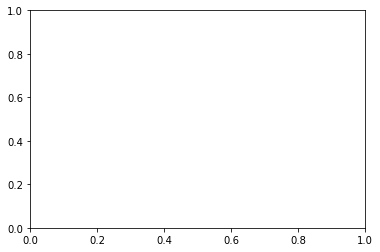

In [10]:
%matplotlib inline

R_list = [0.5, 0.8, 1, 1.5, 2, 3, 4, 5]


plt.plot(R_list, global_dft_list, label='global DFT', color='b')
plt.plot(R_list, global_fci_list, label='global FCI', color='orange')
plt.plot(R_list, global_H_diag_list, label='diag global H', linestyle='dashed', color='darkred')
plt.plot(R_list, huz_H_diag_list, label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, mu_H_diag_list, label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('OH bond length (angstrom)')
plt.ylabel('energy (Ha)')
plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

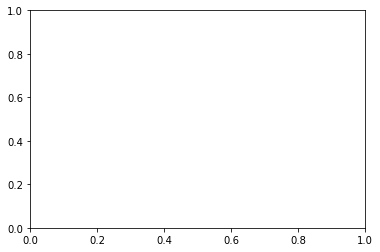

In [11]:
%matplotlib inline

R_list = [0.5, 0.8, 1, 1.5, 2, 3, 4, 5]


plt.plot(R_list, abs(np.array(global_dft_list) - np.array(global_fci_list)), label='global DFT', color='b')
plt.plot(R_list, abs(np.array(huz_H_diag_list) - np.array(global_fci_list)), label='huz emb', linestyle='dashed', marker='o', color='g')
plt.plot(R_list, abs(np.array(mu_H_diag_list) - np.array(global_fci_list)), label='mu emb', linestyle='-', marker='x', color='r')

plt.xlabel('OH bond length (angstrom)')
plt.ylabel('Error (Ha)')
plt.grid(True)
# plt.savefig("test.png")
plt.legend()
plt.show()

In [12]:
geometry_path  = list_file_paths[3]
projector = 'both'#'both', 'huzinaga'  

driver = NbedDriver(
        geometry=geometry_path,
        n_active_atoms=n_active_atoms,
        basis=basis,
        xc_functional=xc_functional,
        projector=projector,
        localization=localization,
        convergence=convergence,
        charge=charge,
        mu_level_shift=mu_level_shift,
        run_ccsd_emb=run_ccsd_emb,
        run_fci_emb=run_fci_emb,
        max_ram_memory=max_ram_memory,
        pyscf_print_level=pyscf_print_level,
        unit=unit,
        occupied_threshold=occupied_threshold,
        virtual_threshold=virtual_threshold,
        max_hf_cycles=max_hf_cycles)

In [ ]:
np.array([[-2.01840000e+01,-0.00000000e+00,-0.00000000e+00,0.00000000e+00
  -0.00000000e+00,0.00000000e+00,0.00000000e+00],
 [-0.00000000e+00, -7.96000000e-01,  0.00000000e+00,  0.00000000e+00,
  -0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
 [-0.00000000e+00,  0.00000000e+00, -3.46000000e-01,  0.00000000e+00,
  -0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.24000000e-01,
   0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
 [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
   2.53000000e-01, -0.00000000e+00, -0.00000000e+00],
 [ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
  -0.00000000e+00,  8.93000000e-01, -0.00000000e+00],
 [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
  -0.00000000e+00, -0.00000000e+00,  9.99999501e+05]])

In [13]:
mu_scf = driver._mu["scf"]
huz_scf = driver._huzinaga["scf"]
global_scf = driver._global_hf

In [14]:
c_mat = mu_scf.mo_coeff
mo_occ = mu_scf.get_occ()
dmat = mu_scf.make_rdm1(mo_coeff=c_mat, mo_occ=mo_occ)
F =  mu_scf.get_fock(dm=dmat)

print(np.around(c_mat.T @ F @c_mat,
         3))

[[-20.184  -0.      0.      0.     -0.      0.   ]
 [ -0.     -0.796  -0.      0.     -0.      0.   ]
 [  0.     -0.     -0.346   0.     -0.     -0.   ]
 [  0.      0.      0.     -0.324   0.      0.   ]
 [ -0.     -0.     -0.      0.      0.253  -0.   ]
 [  0.      0.     -0.      0.     -0.      0.893]]


In [15]:
c_mat = huz_scf.mo_coeff
mo_occ = huz_scf.get_occ()
dmat = huz_scf.make_rdm1(mo_coeff=c_mat, mo_occ=mo_occ)
F =  huz_scf.get_fock(dm=dmat)

print(np.around(c_mat.T @ F @c_mat,
         3))

[[-20.184   0.     -0.     -0.     -0.      0.   ]
 [  0.     -0.796  -0.      0.     -0.      0.   ]
 [ -0.     -0.     -0.346  -0.     -0.      0.   ]
 [ -0.      0.     -0.     -0.324  -0.     -0.   ]
 [ -0.     -0.     -0.     -0.      0.253  -0.   ]
 [  0.      0.      0.     -0.     -0.      0.893]]


In [ ]:
n_act_mo = len(driver.localized_system.active_MO_inds)
n_env_mo = len(driver.localized_system.enviro_MO_inds)

In [ ]:
mu_scf.make_rdm1()

In [ ]:
c_mat = mu_scf.mo_coeff
mo_occ = mu_scf.get_occ()
dmat = mu_scf.make_rdm1(mo_coeff=c_mat, mo_occ=mo_occ)
F =  mu_scf.get_fock(dm=dmat)

print(np.around(c_mat.T @ F @c_mat,
         3))

In [ ]:
[[-2.01840000e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.24000000e-01 -0.00000000e+00]
 [ 0.00000000e+00 -7.96000000e-01  0.00000000e+00  0.00000000e+00
   2.98000000e-01 -0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.46000000e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.53000000e-01
  -3.00000000e-03 -0.00000000e+00]
 [ 6.24000000e-01  2.98000000e-01  0.00000000e+00 -3.00000000e-03
   9.99999501e+05 -9.60000000e-02]
 [-0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  -9.60000000e-02  8.93000000e-01]]


In [ ]:
 mu_scf.mo_coeff

In [ ]:
np.around(abs(huz_scf.mo_coeff -  mu_scf.mo_coeff), 4)

In [ ]:
c_mat = huz_scf.mo_coeff
mo_occ = huz_scf.get_occ()
dmat = huz_scf.make_rdm1(mo_coeff=c_mat, mo_occ=mo_occ)
F =  huz_scf.get_fock(dm=dmat)

print(np.around(c_mat.T @ F @c_mat,
         3))

In [ ]:
c_mat = mu_scf.mo_coeff
mo_occ = mu_scf.get_occ()
dmat = mu_scf.make_rdm1(mo_coeff=c_mat, mo_occ=mo_occ)
F =  mu_scf.get_fock(dm=dmat)
c_mat = huz_scf.mo_coeff
print(np.around(c_mat.T @ F @c_mat,
         2))